In [ ]:
#Conect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Feature Extraction

In this part we show the code to extract the features to train the regression model, this method is based on extract the feature maps of the hidden layers until the layer that will be transferred, then the entropy of the feature maps and the global average pooling layer. These values are used to train the regression model.


In [ ]:
DATASET_NAMES = ['50words','Adiac','ArrowHead','Beef','BeetleFly','BirdChicken','Car','CBF','ChlorineConcentration','CinC_ECG_torso',
                 'Coffee','Computers','Cricket_X', 'Cricket_Y','Cricket_Z','DiatomSizeReduction','DistalPhalanxOutlineAgeGroup','DistalPhalanxOutlineCorrect','DistalPhalanxTW',
                 'Earthquakes','ECG200','ECG5000','ECGFiveDays','ElectricDevices','FaceAll','FaceFour','FacesUCR','FISH','FordA','FordB',
                 'Gun_Point','Ham','HandOutlines','Haptics','Herring','InlineSkate','InsectWingbeatSound','ItalyPowerDemand','LargeKitchenAppliances','Lighting2',
                 'Lighting7','MALLAT','Meat','MedicalImages','MiddlePhalanxOutlineAgeGroup','MiddlePhalanxOutlineCorrect','MiddlePhalanxTW','MoteStrain','NonInvasiveFatalECG_Thorax1','NonInvasiveFatalECG_Thorax2',
                 'OliveOil','OSULeaf','PhalangesOutlinesCorrect','Phoneme','Plane','ProximalPhalanxOutlineAgeGroup','ProximalPhalanxOutlineCorrect','ProximalPhalanxTW','RefrigerationDevices','ScreenType',
                 'ShapeletSim','ShapesAll','SmallKitchenAppliances','SonyAIBORobotSurface','SonyAIBORobotSurfaceII','StarLightCurves','Strawberry','SwedishLeaf','Symbols','synthetic_control',
                 'ToeSegmentation1','ToeSegmentation2','Trace','TwoLeadECG','Two_Patterns','UWaveGestureLibraryAll','uWaveGestureLibrary_X','uWaveGestureLibrary_Y','uWaveGestureLibrary_Z','wafer',
                 'Wine','WordsSynonyms','Worms','WormsTwoClass','yoga']
                 
Target_names=['50words','Adiac','ArrowHead','Beef','BeetleFly','BirdChicken','Car','CBF','ChlorineConcentration','CinC_ECG_torso','Coffee',
'Computers','Cricket_X','Cricket_Y','Cricket_Z','DiatomSizeReduction','DistalPhalanxOutlineAgeGroup','DistalPhalanxOutlineCorrect','DistalPhalanxTW',
'Earthquakes','ECG200','ECG5000','ECGFiveDays','ElectricDevices','FaceAll','FaceFour','FacesUCR','FISH','FordA','FordB','Gun_Point','Ham','HandOutlines',
'Haptics','Herring','InlineSkate','InsectWingbeatSound','ItalyPowerDemand','LargeKitchenAppliances','Lighting2','Lighting7','MALLAT','Meat','MedicalImages',
'MiddlePhalanxOutlineAgeGroup','MiddlePhalanxOutlineCorrect','MiddlePhalanxTW','MoteStrain','NonInvasiveFatalECG_Thorax1','NonInvasiveFatalECG_Thorax2','OliveOil',
'OSULeaf','PhalangesOutlinesCorrect','Phoneme','Plane','ProximalPhalanxOutlineAgeGroup','ProximalPhalanxOutlineCorrect','ProximalPhalanxTW','RefrigerationDevices',
'ScreenType','ShapeletSim','ShapesAll','SmallKitchenAppliances','SonyAIBORobotSurface','SonyAIBORobotSurfaceII','StarLightCurves','Strawberry','SwedishLeaf','Symbols',
'synthetic_control','ToeSegmentation1','ToeSegmentation2','Trace','TwoLeadECG']

In [ ]:
# Load the files of dataset (Code of Fawaz et al.)
def readucr(filename):
    data = np.loadtxt(filename, delimiter = ',')
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

# Return the entropy of a histogram
def entropy(kernel):
	pI=kernel/kernel.sum()
	y=[]
	for i in pI:
		if i==0:
			y.append(0)
		else:
			y.append(np.log2(i))
	return -np.sum(pI*y)

# Return the histogram of the feature map
def getHistogram(array):
	if np.amax(array)==0:
		return np.histogram(np.array(array)/0.000001,bins=(np.arange(101)/100))[0]
	return np.histogram(np.array(array)/np.amax(array),bins=(np.arange(101)/100))[0]

In [ ]:
import keras
import numpy as np
import operator
# Create base model, this part of the code is part of the official code
# from the paper of Transfer Learning for Time Series (Code of Fawaz et al.)
#
# In this part we extract the outputs of the convolutional layers and the gap 
#layer
def build_model(input_shape, nb_classes, pre_model=None):
	input_layer = keras.layers.Input(input_shape)

	conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
	conv1 = keras.layers.normalization.BatchNormalization()(conv1)
	conv1 = keras.layers.Activation(activation='relu')(conv1)

	conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
	conv2 = keras.layers.normalization.BatchNormalization()(conv2)
	conv2 = keras.layers.Activation('relu')(conv2)

	conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
	conv3 = keras.layers.normalization.BatchNormalization()(conv3)
	conv3 = keras.layers.Activation('relu')(conv3)

	gap_layer = keras.layers.pooling.GlobalAveragePooling1D()(conv3)

	output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)
  
	model = keras.models.Model(inputs=input_layer, outputs=output_layer)
	model = keras.models.Model(inputs=input_layer, outputs=[model.layers[-2].output,
                                                          model.layers[-3].output,
                                                          model.layers[-6].output,
                                                          model.layers[-9].output])

	if pre_model is not None:

		for i in range(len(model.layers)-2):
			model.layers[i].set_weights(pre_model.layers[i].get_weights())

	model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(),
		metrics=['accuracy'])

	return model

In [ ]:
# Layer_1 ==> 128 filtros
# Layer_2 ==> 256 filtros
# Layer_3 ==> 128 filtros

# root folder with the datsets
root_folder='/content/drive/MyDrive/UCR_Archive/'

# Extraction of the entropies of the convolutional layers
def entropies_Conv(conv):
  entropies_conv=[]
  for instance in conv:
    kernel_entropies=[]
    for kernel in instance:
      kernel_entropies.append(entropy(getHistogram(kernel)))
    entropies_conv.append(kernel_entropies)
  return np.mean(np.array(entropies_conv), axis=0).tolist()

for source in DATASET_NAMES:
  # Load the source model
  model=keras.models.load_model(root_folder+'UCR_TS_Archive_2015_Models/'+source+'/best_model.hdf5')
  for target in Target_names:
    print('From:', source, ' to:', target)
    # open the dataset, we only use the training set without their labels
    file_name = root_folder+'UCR_TS_Archive_2015/'+target+'/'+target
    x_train, y_train = readucr(file_name+'_TRAIN')
    nb_classes = len(np.unique((y_train), axis=0))
    if len(x_train.shape) == 2:
      x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
    input_shape = ( x_train.shape[1], x_train.shape[2])

    #create the new model with the output of the gap layer
    new_model = build_model(input_shape, nb_classes, model)

    
    output_gap_layer, conv_1, conv_2, conv_3 =new_model.predict(np.array(x_train))
    conv_1=np.rollaxis(conv_1, 2,1)
    conv_2=np.rollaxis(conv_2, 2,1)
    conv_3=np.rollaxis(conv_3, 2,1)
    
    #find the entropies of the gap layer
    entropies_gap=[]
    for i in range(output_gap_layer.shape[1]):
      entropies_gap.append(entropy(getHistogram(output_gap_layer[:,i])))
    
    
    #find the entropy of the convolutional layers
    features=entropies_Conv(conv_1)+entropies_Conv(conv_2)+entropies_Conv(conv_3)+entropies_gap
    print(len(features))
    np.save(root_folder+'Entropies_Full/'+source+'_'+target+'.npy', np.array(features))

# Parameter search for the regression model

In this part we search the best hiperparameters that obtain the best performance in source task selection.

In [ ]:
# Import necessary dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
# The root folder with the dataset and the results of the transfer learning
# stage, also the results of Fawaz et al. 
root_folder='/content/drive/MyDrive/UCR_Archive/'
df_transfer=pd.read_csv(root_folder+'df_transfer.csv', index_col=0)
df_accuracy=pd.read_csv(root_folder+'df_transfer_acc.csv', index_col=0)

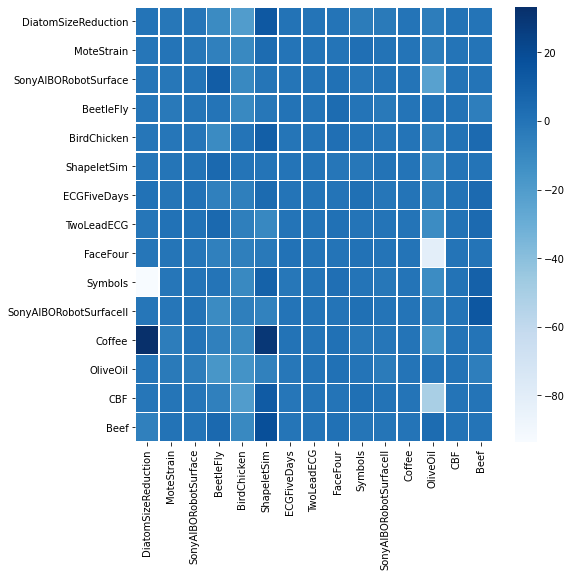

In [ ]:
# We select 15/85 datasets, those are the datasets with the lower instances in
# the training set
selected_datasets=['DiatomSizeReduction', 'MoteStrain', 'SonyAIBORobotSurface','BeetleFly',
                   'BirdChicken','ShapeletSim','ECGFiveDays','TwoLeadECG','FaceFour','Symbols',
                   'SonyAIBORobotSurfaceII', 'Coffee', 'OliveOil', 'CBF','Beef']

# Here we show the performance matrix when the model is transferred
matrix=[]
for source in selected_datasets:
  for target in selected_datasets:
    matrix.append(df_transfer.loc[source, target])
matrix=np.reshape(np.array(matrix),(15,15))
fig,axn = plt.subplots(sharex=True, sharey=True, figsize=(8,8))
sns.heatmap(matrix, yticklabels=selected_datasets, xticklabels=selected_datasets, linewidth=0.5, cmap=sns.color_palette("Blues", as_cmap=True, n_colors=60))
plt.show()

In [ ]:
# Search of the hyperparameters of random forest, we change the quality measure
# (MSE and MAE) and the number of trees from 10 to 150
def parametersSearch_RandomForest():
	criterion=['mse', 'mae']
	n_estimators=[10,151]
	for n_estimators in range(n_estimators[0], n_estimators[1]):
		for c in criterion:
			yield [n_estimators, c]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from joblib import dump

x=[]
y=[]



# Here we find the relative performane when the model is transferred:
#     performance with transfer
# y=_____________________________
#     performance form scratch
#
for source in selected_datasets:
  for target in selected_datasets:
    if source != target:
      x.append(np.load(root_folder+'Entropies_Full/'+source+'_'+target+'.npy'))
      real=(df_accuracy.loc[target, source]*10000)/(df_accuracy.loc[target, source]+100)
      y.append(df_accuracy.loc[source, target]*100/real)


In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from joblib import dump
import joblib

# Evaluation of the regression model
# Precision at first, second and third position
def get_pr(pres):
  prec_at_k=[]
  for i in pres:
    prec_at_k.append([i[0]/1.0, (i[0]+i[1])/2.0, (i[0]+i[1]+i[2])/3.0])
  return np.mean(np.array(prec_at_k),axis=0)

# Maximum performance in the transfer learning stage
maximums=[]
for target in DATASET_NAMES:
  real_positions=[]
  for source in DATASET_NAMES:
    real_positions.append(df_transfer.loc[source, target])
  maximums.append(df_transfer.loc[DATASET_NAMES[real_positions.index(max(real_positions))], target])



positions_baselines=[]

def new_evaluation(regressor):
  #positions_top_1=[]
  top_1=0
  pres=[]
  useful_avg=[]
  top_1_position=[]
  for target in DATASET_NAMES:
    
    real_positions=[]
    predicted=[]
    
    #print('----------------------Target',target,'----------------------')
    for source in DATASET_NAMES:
      real_positions.append(df_transfer.loc[source, target])
      predicted.append(regressor.predict([np.load(root_folder+'Entropies_Full/'+source+'_'+target+'.npy')])[0])
    maximum=max(real_positions)
    cont=0
    useful=0

    # useful position
    for i in np.array(predicted).argsort().tolist()[::-1]:
      if real_positions[i]>=0.0:
        positions_baselines.append(cont+1)
        useful=cont+1
        useful_avg.append(cont+1)
        if cont==0:
          top_1+=1
        #cont=-1
        break
      cont+=1
    
    # precision en 1, 2 y 3 
    p=[]
    for i in np.array(predicted).argsort().tolist()[::-1][:3]:
      if real_positions[i]>=0.0:
        p.append(1)
      else: 
        p.append(0)
    pres.append(p)
    
    #postion of top_1
    sorted=[]
    for i in np.array(predicted).argsort().tolist()[::-1]:
      sorted.append(real_positions[i])
    top_1_position.append(sorted.index(maximum)+1)

  pr=get_pr(pres)
  return str(top_1_position.count(1))+', '+str(np.mean(np.array(top_1_position)))+', '+str(max(useful_avg))+', '+str(np.mean(np.array(useful_avg)))+', '+str(pr[0])+', '+str(pr[1])+', '+str(pr[2])   

#Evalution of a regressor that is saved
#regressor=joblib.load('/content/drive/MyDrive/UCR_Archive/Regressor_full/RandomForest_nestimators_28_criterion_mae.joblib')
#print(new_evaluation(regressor))


# Parameter search
print('n_estimators, criterion, top-1, top_1_avg, max_useful, useful_avg, p@1, p@2, p@3')
for configuration in parametersSearch_RandomForest():
  regressor=RandomForestRegressor(n_estimators=configuration[0], criterion=configuration[1])
  regressor.fit(x,y)
  print(configuration[0],',',configuration[1],', ',new_evaluation(regressor))
  dump(regressor,root_folder+'Regressor_full/RandomForest_nestimators_'+str(configuration[0])+
       '_criterion_'+str(configuration[1])+'.joblib')

n_estimators, criterion, top-1, top_1_avg, max_useful, useful_avg, p@1, p@2, p@3
10 , mse ,  6, 31.68235294117647, 57, 3.211764705882353, 0.5176470588235295, 0.5117647058823529, 0.5058823529411763
10 , mae ,  7, 32.48235294117647, 23, 3.176470588235294, 0.5411764705882353, 0.5058823529411764, 0.4901960784313727
11 , mse ,  6, 32.588235294117645, 73, 3.8, 0.5294117647058824, 0.5176470588235295, 0.4862745098039217
11 , mae ,  6, 29.905882352941177, 41, 3.235294117647059, 0.5058823529411764, 0.49411764705882355, 0.5019607843137257
12 , mse ,  9, 33.588235294117645, 41, 3.0823529411764707, 0.5882352941176471, 0.5294117647058824, 0.5411764705882354
12 , mae ,  6, 31.2, 49, 3.7529411764705882, 0.5411764705882353, 0.5058823529411764, 0.49411764705882344
13 , mse ,  9, 34.27058823529412, 38, 3.1411764705882352, 0.5294117647058824, 0.49411764705882355, 0.5058823529411763
13 , mae ,  8, 30.48235294117647, 43, 3.447058823529412, 0.47058823529411764, 0.49411764705882355, 0.49411764705882344
14 , m

# Evaluation of State of the Art

In [ ]:
def get_pr(pres):
  prec_at_k=[]
  for i in pres:
    prec_at_k.append([i[0]/1.0, (i[0]+i[1])/2.0, (i[0]+i[1]+i[2])/3.0])
  return np.mean(np.array(prec_at_k),axis=0)

# You can change the paper to evaluate
# Fawaz et al.
df_results=pd.read_csv(root_folder+'similar_datasets.csv', index_col=0)
# Meiseles et al.
#df_results=pd.read_csv(root_folder+'Amiel_Meiseles.csv', index_col=0)

top_1=0
positive=0
neutral=0
# Reivision de que los dataset encontraron neutros o positivos
dataset_check=np.zeros(85).tolist()
#Posiciones donde se recuper un positivo o neutro
dataset_positions=np.zeros(85).tolist()

# Se sacan los maximos de los datasets
maximums=[]
for target in DATASET_NAMES:
  real_positions=[]
  for source in DATASET_NAMES:
    real_positions.append(df_transfer.loc[source, target])
  maximums.append(df_transfer.loc[DATASET_NAMES[real_positions.index(max(real_positions))], target])


# Donde se recupera un útil
useful=[]
precisions=[]
pr_results=False


for target in range(len(DATASET_NAMES)):
  # Donde se recupera un útil 
  for source in range(len(DATASET_NAMES)-1): 
    if df_transfer.loc[df_results.loc[DATASET_NAMES[target], 'K_'+str(source+1)], DATASET_NAMES[target]]>=0.0:
      dataset_positions[target]=source+1
      if pr_results:
        print(source+1)
      useful.append(source+1)
      break

  #Precisión en 1ra, 2da y 3ra
  pres=[]
  for i in range(1,4):
    if df_transfer.loc[df_results.loc[DATASET_NAMES[target], 'K_'+str(i)], DATASET_NAMES[target]]>=0.0:
      pres.append(1)
    else: 
      pres.append(0)
  precisions.append(pres)

  top_1_position=[]
  
  for source in range(len(DATASET_NAMES)-1): 
    if df_transfer.loc[df_results.loc[DATASET_NAMES[target], 'K_'+str(source+1)], DATASET_NAMES[target]]==maximums[target]:
      top_1_position.append(source+1)
      if source==0:
        top_1+=1

print('Useful position average:',np.mean(np.array(useful)),'+/-',np.std(np.array(useful)))
print('Precisions in 1, 2, 3:', get_pr(precisions))
print('Top_1 pocision average:', np.mean(np.array(top_1_position)))
print('Top_1 precision:', top_1/85.0)
print('Max useful: ',max(useful))

Useful position average: 2.5764705882352943 +/- 4.666215170118158
Precisions in 1, 2, 3: [0.65882353 0.61764706 0.63137255]
Top_1 pocision average: 44.0
Top_1 precision: 0.09411764705882353
Max useful:  37


,K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8,K_9,K_10,K_11,K_12,K_13,K_14,K_15,K_16,K_17,K_18,K_19,K_20,K_21,K_22,K_23,K_24,K_25,K_26,K_27,K_28,K_29,K_30,K_31,K_32,K_33,K_34,K_35,K_36,K_37,K_38,K_39,K_40,K_41,K_42,K_43,K_44,K_45,K_46,K_47,K_48,K_49,K_50,K_51,K_52,K_53,K_54,K_55,K_56,K_57,K_58,K_59,K_60,K_61,K_62,K_63,K_64,K_65,K_66,K_67,K_68,K_69,K_70,K_71,K_72,K_73,K_74,K_75,K_76,K_77,K_78,K_79,K_80,K_81,K_82,K_83,K_84,


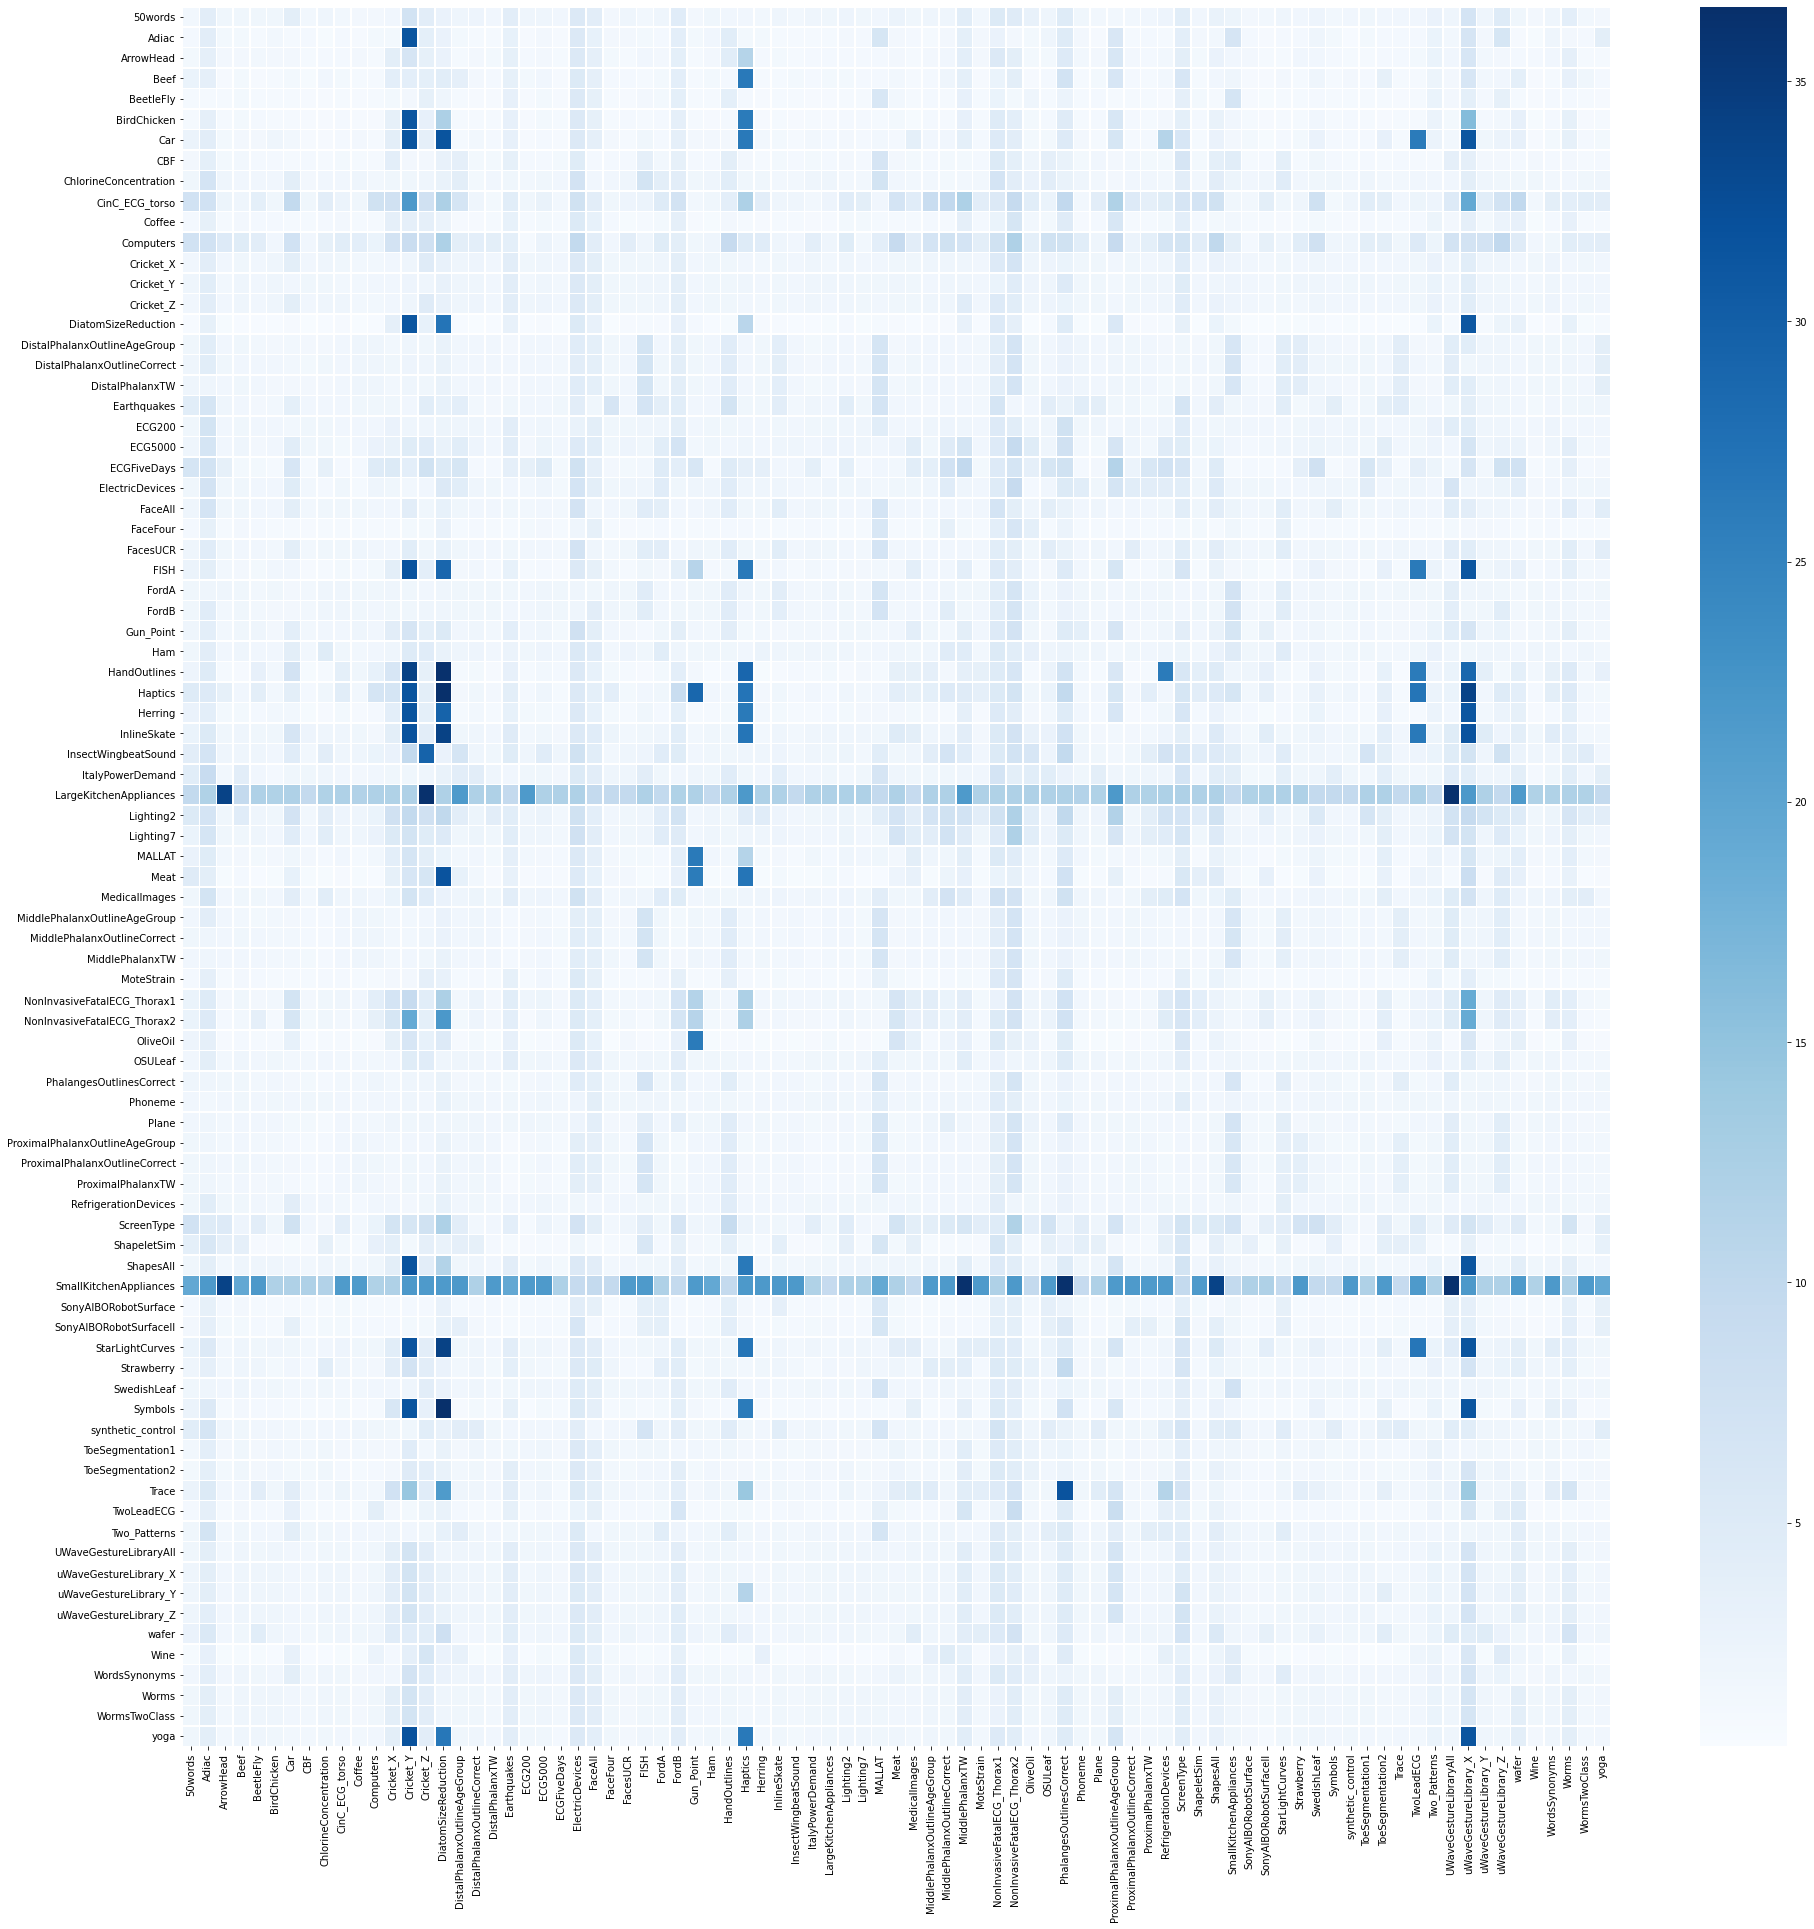

In [ ]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig,axn = plt.subplots(sharex=True, sharey=True, figsize=(32,32))
root_folder='/content/drive/MyDrive/UCR_Archive/'
df_transfer=pd.read_csv(root_folder+'df_transfer.csv', index_col=0)

headers=','
for i in range(84):
  headers+='K_'+str(i+1)+','
print(headers)

def new_evaluation(regressor):
  prediction_matrix=[]
  for target in DATASET_NAMES:
    
    real_positions=[]
    predicted=[]
    
    for source in DATASET_NAMES:
      real_positions.append(df_transfer.loc[source, target])
      predicted.append(regressor.predict([np.load(root_folder+'Entropies_Full/'+source+'_'+target+'.npy')])[0])
    prediction_matrix.append(predicted)
    #exit=target+','
    # useful position
    #for i in np.array(predicted).argsort().tolist()[::-1]:
    #  exit+=DATASET_NAMES[i]+','
    #print(exit) 
  sns.heatmap(np.array(prediction_matrix), yticklabels=DATASET_NAMES, xticklabels=DATASET_NAMES, linewidth=0.5, cmap=sns.color_palette("Blues", as_cmap=True, n_colors=60))
  plt.show()

#Evaluation of a regressor that is saved
regressor=joblib.load('/content/drive/MyDrive/UCR_Archive/Regressor_full/RandomForest_nestimators_18_criterion_mse.joblib')

new_evaluation(regressor)